In [54]:
import datetime as dt
import os
import xarray as xr
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import functions.common as cf
import calendar
import pytz
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
pd.set_option('display.width', 320, "display.max_columns", 15)  # for display in pycharm console
plt.rcParams.update({'font.size': 12})  # all font sizes are 12 unless otherwise specified

In [58]:
#arguments

#point = [39.17745, -74.18033]
lease_site = "OCS-A0000"
lat = 39.4
lon = -73.8
start_date = dt.datetime(2022, 6, 1, 0, 0)  
end_date = dt.datetime(2022, 8, 31, 23, 0)

# grab the location of the specified site
# need to update this #
point = [lat,lon]



In [59]:
# import WRF data link 
mlink = 'http://tds.marine.rutgers.edu/thredds/dodsC/cool/ruwrf/wrf_4_1_3km_processed/WRF_4.1_3km_Processed_Dataset_Best'
ds = xr.open_dataset(mlink)
ds = ds.sel(time=slice(start_date, end_date))

In [60]:
# Find the nearest latitude and longitude in the dataset

 # calculate the sum of the absolute value distance between the model location and buoy location
a = abs(ds['XLAT'] - point[0]) + abs(ds['XLONG'] - point[1])

# find the indices of the minimum value in the array calculated above
i, j = np.unravel_index(a.argmin(), a.shape)

# get u and v component, calculate windspeed and estimated wind power
u = ds.sel(height=160)['U'][:, i, j]
v = ds.sel(height=160)['V'][:, i, j]
ws = cf.wind_uv_to_spd(u,v)

ws_df = ws.to_dataframe('windspeed')

In [61]:
# create Power
power_curve =pd.read_csv('/Users/jameskim/Documents/rucool/Repositories/wind-science/files/wrf_lw15mw_power.csv')

# Interpolate power values and add a new column 'Power' to ws_df
ws_df['Power'] = np.interp(ws_df['windspeed'], power_curve['Wind Speed'], power_curve['Power'])


In [62]:
# Extract hour from the index of ws_df and convert to EST
est = pytz.timezone('US/Eastern')  # Define the Eastern Timezone
ws_df.index = ws_df.index.tz_localize('GMT').tz_convert(est)  # Convert time to EST


In [63]:
# Extract hour from the index of ws_df
ws_df['hour'] = ws_df.index.hour

<Figure size 640x480 with 0 Axes>

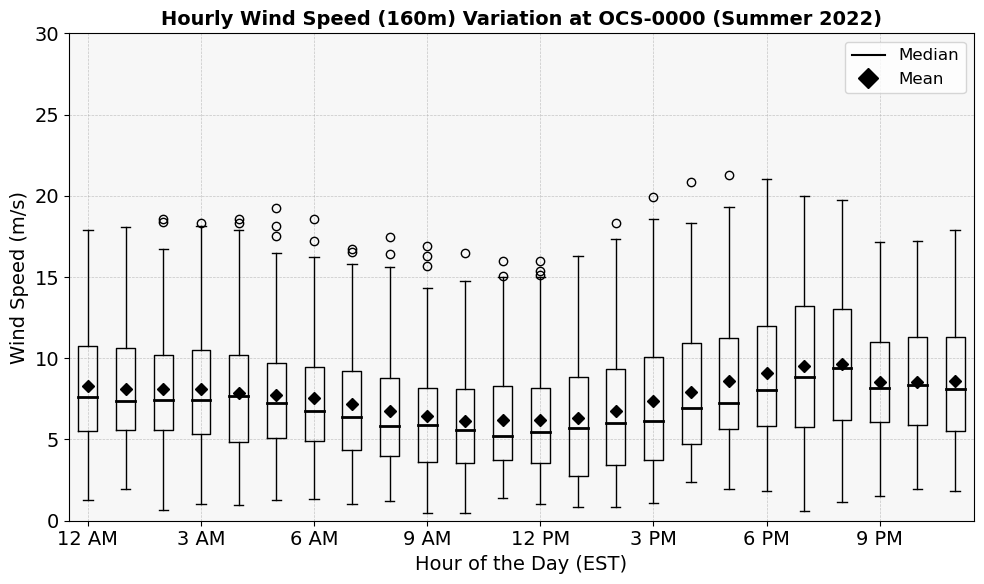

In [69]:
# customize the boxplot elements


# Clear the current figure
plt.clf()

medianprops = dict(linestyle = "-", color='black',linewidth  = 2)
meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='black')

plt.figure(figsize=(10, 6))
box = plt.boxplot([group['windspeed'] for name, group in ws_df.groupby('hour')], showfliers=True, patch_artist=False,showmeans=True,medianprops=medianprops,meanprops = meanpointprops)

plt.xlabel('Hour of the Day (EST)', fontsize=14)
plt.ylabel('Wind Speed (m/s)', fontsize=14)
plt.title(f'Hourly Wind Speed (160m) Variation at OCS-0000 (Summer 2022)', fontsize=14, fontweight = 'bold')

# convert to coordinal time
plt.xticks(ticks=np.arange(1, 25, 3), labels=[str((i % 12) if i % 12 else 12) + (' PM' if i >= 12 else ' AM') for i in range(0, 24, 3)])

# Customizing gridlines
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a background grid to the plot
plt.gca().set_facecolor('#f7f7f7')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

# Setting y-axis limits
plt.ylim(0, 30)

##### legend ####

# Create legends for the median and mean without the additional line
median_legend = mlines.Line2D([], [], color='black', label='Median')
mean_legend = mlines.Line2D([], [], marker='D', markerfacecolor='black', markeredgecolor='black', markersize=10, label='Mean', linestyle='None')

plt.legend(handles=[median_legend, mean_legend], loc='upper right')

plt.show()

<Figure size 640x480 with 0 Axes>

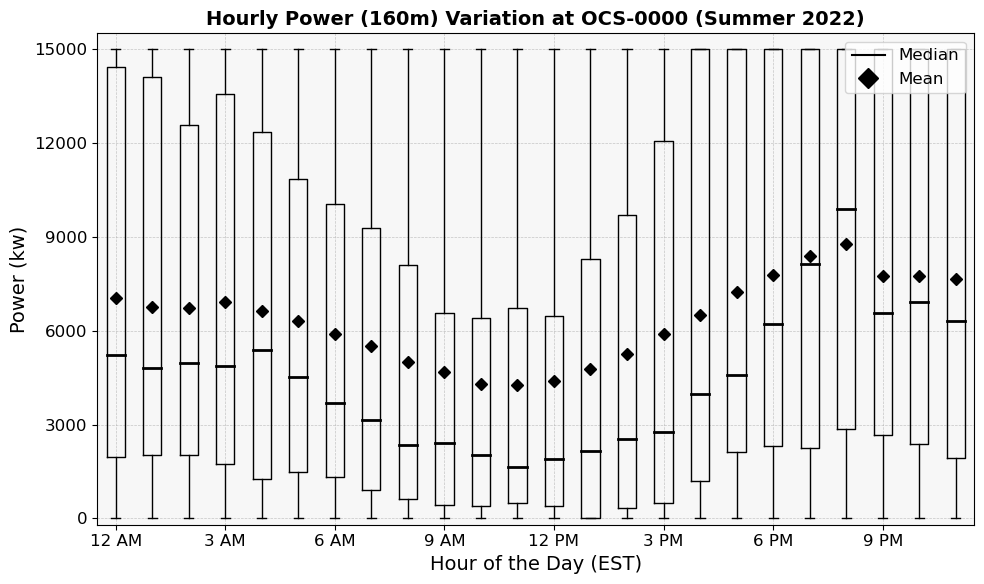

In [70]:
# Clear the current figure
plt.clf()

medianprops = dict(linestyle="-", color='black', linewidth=2)
meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='black')

plt.figure(figsize=(10, 6))
box = plt.boxplot([group['Power'] for name, group in ws_df.groupby('hour')],
                 showfliers=True, patch_artist=False, showmeans=True,
                 medianprops=medianprops, meanprops=meanpointprops)

plt.xlabel('Hour of the Day (EST)', fontsize=14)
plt.ylabel('Power (kw)', fontsize=14)
plt.title(f'Hourly Power (160m) Variation at OCS-0000 (Summer 2022)', fontsize=14, fontweight = "bold")

# Convert to coordinate time
plt.xticks(ticks=np.arange(1, 25, 3),
           labels=[str((i % 12) if i % 12 else 12) + (' PM' if i >= 12 else ' AM') for i in range(0, 24, 3)])

# Customizing gridlines
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a background grid to the plot
plt.gca().set_facecolor('#f7f7f7')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()

# Set y-axis limits with a little padding
plt.ylim(-200, 15500)

# Set y-axis ticks manually
plt.yticks([0,3000, 6000, 9000, 12000, 15000])

# Legend
median_legend = mlines.Line2D([], [], color='black', label='Median')
mean_legend = mlines.Line2D([], [], marker='D', markerfacecolor='black', markeredgecolor='black', markersize=10, label='Mean', linestyle='None')

plt.legend(handles=[median_legend, mean_legend], loc='upper right')

plt.show()



In [ ]:
def get_month_dates(month=None, season=None, start_year=None, end_year=None):
    if month and season:
        raise ValueError("Please provide either 'month' or 'season', not both.")

    if month:
        # Convert month name to its numerical representation
        month_number = dt.strptime(month, '%B').month

        results = []
        for year in range(start_year, end_year + 1):
            # Calculate the first day of the month
            start_date = dt(year, month_number, 1)

            # Calculate the last day of the month
            if month_number == 12:
                end_date = dt(year + 1, 1, 1) - timedelta(days=1)
            else:
                end_date = dt(year, month_number + 1, 1) - timedelta(days=1)

            # Format dates as strings
            start_date_str = start_date.strftime('%Y-%m-%d')
            end_date_str = end_date.strftime('%Y-%m-%d')

            # Create a string with just the month and year
            month_year_str = f"{month} {year}"

            results.append((start_date_str, end_date_str, month_year_str))

        return results

    elif season:
        # Define seasons and their corresponding months
        seasons = {
            'spring': range(3, 6),
            'summer': range(6, 9),
            'fall': range(9, 12),
            'winter': [12, 1, 2]
        }

        # Check if the provided season is valid
        if season.lower() not in seasons:
            raise ValueError(f"Invalid season: {season}")

        # Get the months corresponding to the season
        season_months = seasons[season.lower()]

        results = []
        for year in range(start_year, end_year + 1):
            # Calculate the first day of the season
            start_date = dt(year, min(season_months), 1)

            # Calculate the last day of the season
            end_date = dt(year, max(season_months) + 1, 1) - timedelta(days=1)

            # Format dates as strings
            start_date_str = start_date.strftime('%Y-%m-%d')
            end_date_str = end_date.strftime('%Y-%m-%d')

            # Create a string with just the season and year
            season_year_str = f"{season.capitalize()} {year}"

            results.append((start_date_str, end_date_str, season_year_str))

        return results

# Example usage:
month_results = get_month_dates(month="January", start_year=2019, end_year=2022)
for start_date, end_date, month_year in month_results:
    print(f"Start date: {start_date}")
    print(f"End date: {end_date}")
    print(f"Month and year: {month_year}")
    print()









Start date: 2019-01-01
End date: 2019-01-31
Month and year: January 2019

Start date: 2020-01-01
End date: 2020-01-31
Month and year: January 2020

Start date: 2021-01-01
End date: 2021-01-31
Month and year: January 2021

Start date: 2022-01-01
End date: 2022-01-31
Month and year: January 2022



In [ ]:
def get_month_dates(month=None, season=None, start_year=None, end_year=None):
    if month and season:
        raise ValueError("Please provide either 'month' or 'season', not both.")

    results = []

    if month:
        # Convert month name to its numerical representation
        month_number = dt.strptime(month, '%B').month

        for year in range(start_year, end_year + 1):
            # Calculate the first day of the month
            start_date = dt(year, month_number, 1)

            # Calculate the last day of the month
            if month_number == 12:
                end_date = dt(year + 1, 1, 1) - timedelta(days=1)
            else:
                end_date = dt(year, month_number + 1, 1) - timedelta(days=1)

            # Format dates as strings
            start_date_str = start_date.strftime('%Y-%m-%d')
            end_date_str = end_date.strftime('%Y-%m-%d')

            # Create a dictionary with column names and values
            result_dict = {
                'start_date': start_date_str,
                'end_date': end_date_str,
                'month_year': f"{month} {year}"
            }

            results.append(result_dict)

    elif season:
        # Define seasons and their corresponding months
        seasons = {
            'spring': range(3, 6),
            'summer': range(6, 9),
            'fall': range(9, 12),
            'winter': [12, 1, 2]
        }

        for year in range(start_year, end_year + 1):
            # Get the months corresponding to the season
            season_months = seasons[season.lower()]

            # Calculate the first day of the season
            start_date = dt(year, min(season_months), 1)

            # Calculate the last day of the season
            end_date = dt(year, max(season_months) + 1, 1) - timedelta(days=1)

            # Format dates as strings
            start_date_str = start_date.strftime('%Y-%m-%d')
            end_date_str = end_date.strftime('%Y-%m-%d')

            # Create a dictionary with column names and values
            result_dict = {
                'start_date': start_date_str,
                'end_date': end_date_str,
                'season_year': f"{season.capitalize()} {year}"
            }

            results.append(result_dict)

    return results

# Example usage:
month_results = get_month_dates(month="August", start_year=2020, end_year=2022)
season_results = get_month_dates(season="Summer", start_year=2020, end_year=2022)

print("Month Results:")
print(month_results)

print("\nSeason Results:")
print(season_results)

Month Results:
[{'start_date': '2020-08-01', 'end_date': '2020-08-31', 'month_year': 'August 2020'}, {'start_date': '2021-08-01', 'end_date': '2021-08-31', 'month_year': 'August 2021'}, {'start_date': '2022-08-01', 'end_date': '2022-08-31', 'month_year': 'August 2022'}]

Season Results:
[{'start_date': '2020-06-01', 'end_date': '2020-08-31', 'season_year': 'Summer 2020'}, {'start_date': '2021-06-01', 'end_date': '2021-08-31', 'season_year': 'Summer 2021'}, {'start_date': '2022-06-01', 'end_date': '2022-08-31', 'season_year': 'Summer 2022'}]
